In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load your dataset
train_df = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
test_df_raw = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

A Gated Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN) designed to capture dependencies in sequential data. It introduces gating mechanisms—specifically, the update and reset gates—that regulate the flow of information, allowing the model to retain or discard information as needed. This architecture addresses challenges like the vanishing gradient problem, enabling GRUs to model long-term dependencies more effectively than traditional RNNs. 

Key Characteristics of GRUs

Update Gate: Determines how much of the past information needs to be passed along to the future.

Reset Gate: Decides how much of the past information to forget.

Simplified Architecture: Compared to Long Short-Term Memory (LSTM) networks, GRUs have a more streamlined structure, often leading to faster training times while maintaining performance.

Source: https://aws.amazon.com/what-is/recurrent-neural-network/

In [2]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
test_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [6]:

# === 2. Feature Engineering: Extract datetime info ===
def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])  # Convert datetime string to timestamp
    df['hour'] = df['datetime'].dt.hour              # Hour of the day (0–23)
    df['day'] = df['datetime'].dt.dayofweek          # Day of the week (0=Monday)
    df['month'] = df['datetime'].dt.month            # Month (1–12)
    df['year'] = df['datetime'].dt.year              # Year (2011 or 2012)
    return df

# Apply time feature extraction
train_df = add_time_features(train_df)
test_df = add_time_features(test_df_raw)

In [7]:
train_df.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,3.013963,6.521495,2011.501929
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2011.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,1.000000,4.000000,2011.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,3.000000,7.000000,2012.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,5.000000,10.000000,2012.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,6.000000,12.000000,2012.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,2.004585,3.444373,0.500019


In [8]:
print(train_df.dtypes)

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
hour                   int32
day                    int32
month                  int32
year                   int32
dtype: object


In [9]:
print(test_df.dtypes)

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
hour                   int32
day                    int32
month                  int32
year                   int32
dtype: object


In [10]:
# === 3. Define input features and target ===
features = ['hour', 'day', 'month', 'year', 'temp', 'humidity', 'windspeed']
target = 'count'  # This is what we want to predict


#===3.5 Dropping unncecessary features
dropFeatures = ["datetime"]
train_df = train_df.drop('casual', axis=1)
train_df = train_df.drop('registered', axis=1)
train_df = train_df.drop(dropFeatures,axis=1)
test_df = test_df.drop(dropFeatures,axis=1)

# === 4. Normalize features using MinMaxScaler ===
scaler = MinMaxScaler()
X_train_all = scaler.fit_transform(train_df[features])  # Fit only on train data
X_test_all = scaler.transform(test_df[features])        # Transform test data using same scaler

# Save target variable separately
y_train_all = np.log1p(train_df['count'].values)
#The following is for ensemble and tree methods


In [11]:

# === 6. Create time-series sequences for GRU ===
def create_sequences(X, y=None, look_back=24):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        if y is not None:
            ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys) if y is not None else np.array(Xs)

look_back = 6  # Using past 6 time value

X_train_seq, y_train_seq = create_sequences(X_train_all, y_train_all, look_back)

#y_train_seq = np.log1p(y_train_seq)

In [12]:
# === 7. Split training data into train/validation ===
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42, shuffle=False
)
# Note: shuffle=False preserves time order, which is critical for time series

# === 8. Build deeper GRU model ===
model = Sequential()
model.add(Bidirectional(GRU(512, return_sequences=True), input_shape=(look_back, len(features))))
#model.add(Dropout(0.05))
model.add(Bidirectional(GRU(128)))
model.add(Dense(1))  # Output: predicted log(count)
model.compile(optimizer='adam', loss='mean_squared_error')


# === 10. Add early stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# === 11. Train model with validation data ===
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 2.1393 - val_loss: 0.4221
Epoch 2/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3986 - val_loss: 0.3224
Epoch 3/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3169 - val_loss: 0.2133
Epoch 4/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2870 - val_loss: 0.2182
Epoch 5/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2639 - val_loss: 0.2270
Epoch 6/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2214 - val_loss: 0.1910
Epoch 7/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2117 - val_loss: 0.1415
Epoch 8/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2023 - val_loss: 0.1773
Epoch 9/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1893 - val_loss: 0.2063
Epoch 10/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1852 - val_loss: 0.1581
Epoch 11/1000
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1641 - val_loss: 0.2467
Epoch 12/1000
272/272 ━━━━━━━

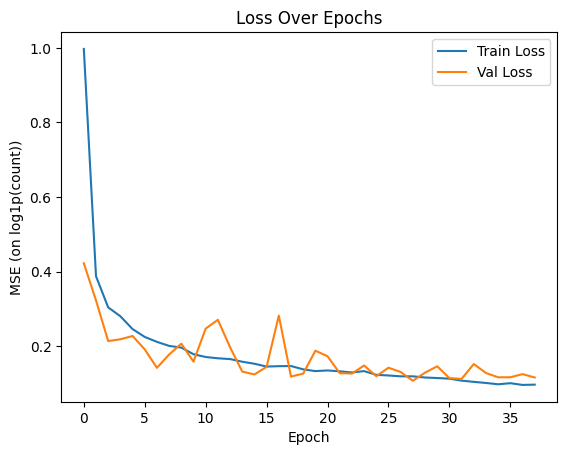

In [13]:
# === 12. Plot training & validation loss ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE (on log1p(count))')
plt.legend()
plt.show()

In [14]:
#We can also check root mean square error if need be

def rmsle(y, y_,convertExp=True):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [15]:
# === 13. Prepare test sequences using last part of train ===
X_test_seq = []
seed_seq = X_train_all[-look_back:].tolist()
for row in X_test_all:
    seed_seq.append(row)
    seq = seed_seq[-look_back:]
    X_test_seq.append(seq)
X_test_seq = np.array(X_test_seq)

# === 14. Predict and inverse log1p ==
test_preds = model.predict(X_test_seq).flatten()


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [16]:

# === 13. Submission file ===
datetimecol = test_df_raw["datetime"]
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(test_preds)]
    })
submission.to_csv('bike_predictions3.csv', index=False)

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000)
gbm.fit(X_train_all, y_train_all)
preds = gbm.predict(X=X_train_all)
print ("RMSLE Value For Gradient Boost: ", rmsle(np.exp(y_train_all), np.exp(preds), False))

RMSLE Value For Gradient Boost:  0.2256738796033782


In [19]:
test_preds2 = gbm.predict(X=X_test_all)

In [20]:
submission2 = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')
datetimecol = test_df_raw["datetime"]
submission2 = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(test_preds2)]
    })
submission2.to_csv('gbr_estt.csv', index=False)

In [21]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
rfModel.fit(X_train_all, y_train_all)
preds = rfModel.predict(X=X_train_all)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_train_all), np.exp(preds), False))

RMSLE Value For Random Forest:  0.11502367206001117


In [22]:
test_pred = rfModel.predict(X=X_test_all)

In [23]:
submission3 = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')
datetimecol = test_df_raw["datetime"]
submission3 = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(test_pred)]
    })
submission3.to_csv('bikeseparate_rf.csv', index=False)

Random forest gace the best result as a public socre 0.39. GRU wasn't the best. However I haven't utilized grid search for the best hyperparameters